In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(100)

In [3]:
data = pd.read_csv('data/yahoo_reduced_arms.csv')
# Reshuffle data
data = data.sample(frac=1, random_state=100)

In [4]:
n_arms = data['selected_arm'].max() + 1
n_arms

22

In [5]:
data.sample(n=5, random_state=100)

,1,2,3,4,5,6,7,8,9,10,...,130,131,132,133,134,135,136,selected_arm,reward,probability
28252,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,0,0.045455
22553,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0.045455
45324,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0.045455
2154,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,19,0,0.045455
37921,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0.045455


There are 22 different arms. They seem to have been chosen uniformly randomly

In [6]:
data['selected_arm'].describe()

count    45791.000000
mean        10.420825
std          6.357193
min          0.000000
25%          5.000000
50%         10.000000
75%         16.000000
max         21.000000
Name: selected_arm, dtype: float64

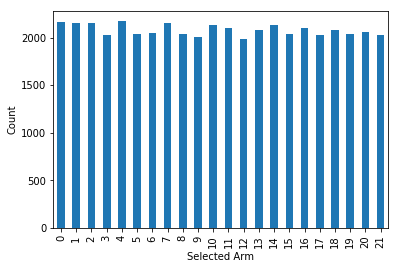

In [7]:
data['selected_arm'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Selected Arm')
plt.ylabel('Count')
plt.show()

The reward is a Bernoulli distribution

In [8]:
data['reward'].describe()

count    45791.000000
mean         0.019109
std          0.136908
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: reward, dtype: float64

The reward expectancy depends on the arm chosen:

Text(0.5,0,'Selected Arm')

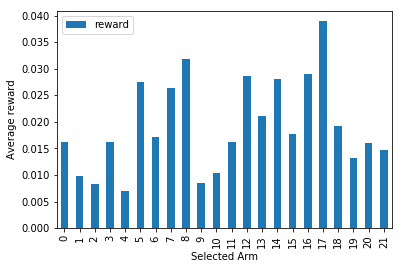

In [9]:
data.groupby('selected_arm').agg({'reward':'mean'}).plot(kind='bar')
plt.ylabel('Average reward')
plt.xlabel('Selected Arm')

All 136 features are bernoulli

In [10]:
class Environment_From_Data():
    def __init__(self, data):
        self.data = data
        self.data_groupby_arms = data.groupby('selected_arm')
    
    def get_reward(self, arm):
        reward = data.loc[np.random.choice(self.data_groupby_arms.groups[arm]), 'reward']
        return reward

In [11]:
environment = Environment_From_Data(data)

# Implementing a simple Explore First strategy

In [12]:
# class Agent():
#     def __init__(self):
        
#     def add_observation(self, features, arm, reward):
    
#     def select_arm(self, features):
#         way_to_best_choose_arm_acccording_to_agent
#         return arm

class GreedyExploreFirst():
    def __init__(self, n_arms, learning_stop):
        self.n_arms = n_arms
        self.learning_stop = learning_stop
        self.tries = np.ones(n_arms)
        self.successes = np.zeros(n_arms)
        
    def add_observation(self, arm, reward):
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        # if learning hasn't stopped yet, chose random arm
        if self.tries.sum() < self.learning_stop:
            arm = random.randint(0, self.n_arms - 1)
        # else chose arm with most success rate
        else:
            success_rate = self.successes / self.tries
            arm = np.random.choice((success_rate == success_rate.max()).nonzero()[0])
        return arm

In [13]:
agent = GreedyExploreFirst(n_arms=n_arms, learning_stop=n_arms*100)
# Setting 100 tries per arm

In [14]:
total_reward = []
T = 10000 # Total testing time
for row in range(int(T)):
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())

In [15]:
agent.select_arm()

17

Text(0,0.5,'Total Reward')

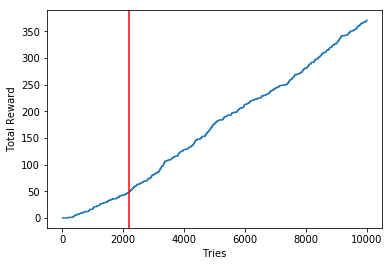

In [16]:
plt.plot(total_reward)
plt.axvline(agent.learning_stop, c='r')
plt.xlabel('Tries')
plt.ylabel('Total Reward')

In [17]:
total_reward[-1]

371.0

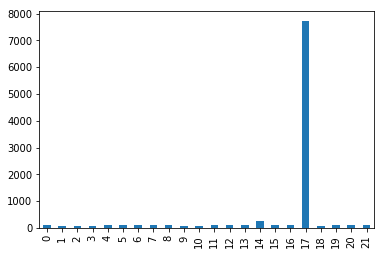

In [18]:
pd.Series(agent.tries).plot.bar()

# Implementing an Epsilon Greedy Strategy

In [19]:
# class Agent():
#     def __init__(self):
        
#     def add_observation(self, features, arm, reward):
    
#     def select_arm(self, features):
#         way_to_best_choose_arm_acccording_to_agent
#         return arm
from scipy.stats import bernoulli

class EpsilonGreedy():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.tries = np.ones(n_arms)
        self.successes = np.zeros(n_arms)
        
    def epsilon(self):
        t = self.tries.sum()
        # value taken from https://arxiv.org/pdf/1904.07272.pdf theorem 1.6
        epsilon = (self.n_arms * np.log(t) / t ) ** (1./3)
        epsilon = min(epsilon, 1)
        return epsilon
    
    def add_observation(self, arm, reward):
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        # if epsilon-weighted coin toss is true, explore
        epsilon = self.epsilon()
        if bernoulli(epsilon).rvs():
            arm = random.randint(0, self.n_arms - 1)
        # else exploit (chose arm with most success rate)
        else:
            success_rate = self.successes / self.tries
            arm = np.random.choice((success_rate == success_rate.max()).nonzero()[0])
        return arm

In [20]:
agent = EpsilonGreedy(n_arms=n_arms)

In [21]:
total_reward = []
epsilon_history = []
for row in range(int(T)):
    epsilon_history.append(agent.epsilon())
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())


In [22]:
agent.select_arm()

17

Text(0,0.5,'Total Reward')

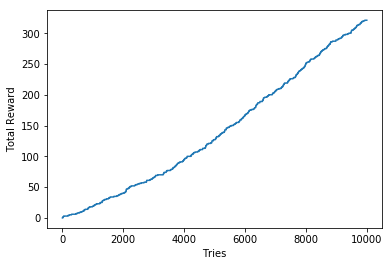

In [23]:
plt.plot(total_reward)
plt.xlabel('Tries')
plt.ylabel('Total Reward')

Text(0,0.5,'Epsilon')

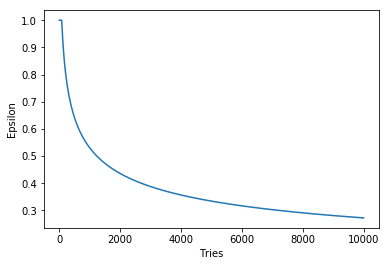

In [24]:
plt.plot(epsilon_history)
plt.xlabel('Tries')
plt.ylabel('Epsilon')

In [25]:
total_reward[-1]

321.0

In [26]:
agent.epsilon()

0.2724473099515813

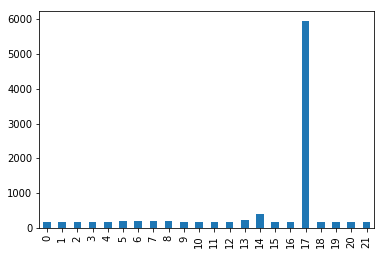

In [27]:
pd.Series(agent.tries).plot.bar()